In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transforms for 299×299
train_tf = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# DataLoaders
# 3) Re‑build your ImageFolder datasets/loaders using these transforms
train_ds = ImageFolder("chestxray14/chest_xray/train", transform=train_tf)
val_ds   = ImageFolder("chestxray14/chest_xray/val",   transform=val_tf)
test_ds  = ImageFolder("chestxray14/chest_xray/test",  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=4)

# Model
weights = Inception_V3_Weights.IMAGENET1K_V1
model = inception_v3(weights=weights, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, 2)
model = model.to(device)

print("Inception v3 ready on", device)


Using device: cpu
Inception v3 ready on cpu


In [ ]:
# 3) Re‑build your ImageFolder datasets/loaders using these transforms
train_ds = ImageFolder("chestxray14/chest_xray/train", transform=train_tf)
val_ds   = ImageFolder("chestxray14/chest_xray/val",   transform=val_tf)
test_ds  = ImageFolder("chestxray14/chest_xray/test",  transform=val_tf)

In [13]:
import torch.nn.functional as F

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Inception returns (logits, aux_logits) during training
        outputs, aux_outputs = model(imgs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss  = loss1 + 0.4 * loss2

        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * imgs.size(0)
        running_corrects+= (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            # in eval mode Inception only returns the main logits
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)

            running_loss    += loss.item() * imgs.size(0)
            running_corrects+= (outputs.argmax(1) == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects / len(loader.dataset)
    return epoch_loss, epoch_acc


In [15]:
import torch.nn as nn
import torch.optim as optim

# ─── Cell X: Loss, Optimizer & Scheduler ──────────────────────────────────────

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, verbose=True
)

print("Criterion, optimizer and scheduler ready.")


Criterion, optimizer and scheduler ready.


c:\Users\saisr\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
NUM_EPOCHS = 1
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = eval_one_epoch(model, val_loader,   criterion, device)
    scheduler.step(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3%} || "
          f"Val   Loss: {val_loss:.3f} | Val   Acc: {val_acc:.3%}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_inceptionv3.pt")
        print("  ↳ New best val acc, checkpoint saved.")


Epoch 01 | Train Loss: 0.169 | Train Acc: 94.881% || Val   Loss: 0.669 | Val   Acc: 62.500%
  ↳ New best val acc, checkpoint saved.


In [19]:
from sklearn.metrics import roc_curve


C:\Users\saisr\AppData\Local\Temp\ipykernel_17192\3785237546.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_inceptionv3.pt"))


Test Accuracy : 75.801%
Test ROC‑AUC  : 0.967
Confusion Matrix:
 [[ 84 150]
 [  1 389]]


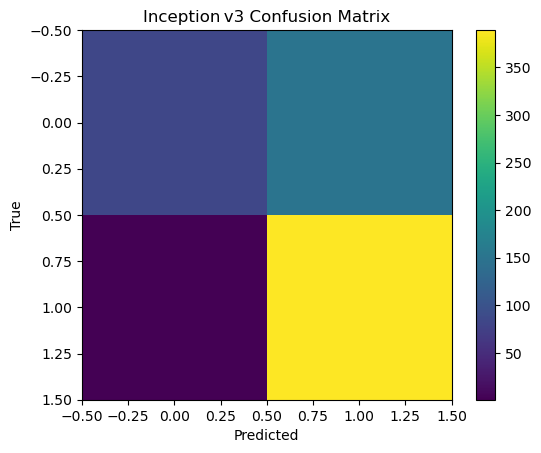

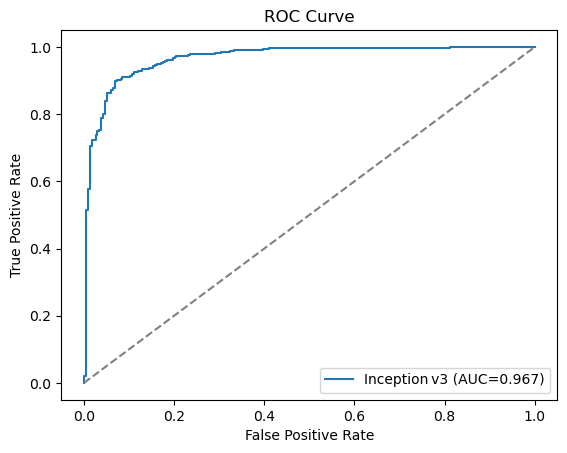

In [20]:
# ─── Fixed Cell 6: Inception v3 Test‑Set Evaluation ────────────────────────────

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# 1) Load best checkpoint (you can add weights_only=True when torch supports it)
model.load_state_dict(torch.load("best_inceptionv3.pt"))
model.eval()

all_labels = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        # In train mode you'd get (logits, aux_logits); in eval you'll get just logits
        logits = out[0] if isinstance(out, tuple) else out

        probs = F.softmax(logits, dim=1)[:,1].cpu().tolist()
        all_probs.extend(probs)
        all_labels.extend(labels.tolist())

# 2) Compute metrics
preds = [1 if p>0.5 else 0 for p in all_probs]
acc   = accuracy_score(all_labels, preds)
auc   = roc_auc_score(all_labels, all_probs)
cm    = confusion_matrix(all_labels, preds)

print(f"Test Accuracy : {acc:.3%}")
print(f"Test ROC‑AUC  : {auc:.3f}")
print("Confusion Matrix:\n", cm)

# 3) Visualize results

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Inception v3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"Inception v3 (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [21]:
import torch.nn.functional as F
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

# 1.1) Rebuild & load your DenseNet‑121
densenet = models.densenet121(pretrained=False)
in_feats  = densenet.classifier.in_features
densenet.classifier = nn.Linear(in_feats, 2)
densenet.load_state_dict(torch.load("best_densenet121.pt"))
densenet = densenet.to(device)
densenet.eval()

# 1.2) Gather predictions & probabilities
dn_labels = []
dn_probs  = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = densenet(imgs)
        probs  = F.softmax(logits, dim=1)[:,1].cpu().tolist()
        dn_probs.extend(probs)
        dn_labels.extend(labels.tolist())

# 1.3) Compute metrics
dn_preds = [1 if p>0.5 else 0 for p in dn_probs]
dn_acc   = accuracy_score(dn_labels, dn_preds)
dn_auc   = roc_auc_score(dn_labels, dn_probs)
dn_cm    = confusion_matrix(dn_labels, dn_preds)
print(f"DenseNet‑121 Test Accuracy : {dn_acc:.3%}")
print(f"DenseNet‑121 Test ROC‑AUC  : {dn_auc:.3f}")
print("DenseNet‑121 Confusion Matrix:\n", dn_cm)


c:\Users\saisr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saisr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\saisr\AppData\Local\Temp\ipykernel_17192\3257514222.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipp

DenseNet‑121 Test Accuracy : 69.391%
DenseNet‑121 Test ROC‑AUC  : 0.916
DenseNet‑121 Confusion Matrix:
 [[ 43 191]
 [  0 390]]


Model         | Accuracy  |   ROC‑AUC
--------------------------------------
DenseNet‑121  | 69.391% | 0.916
Inception v3  | 75.801% | 0.967


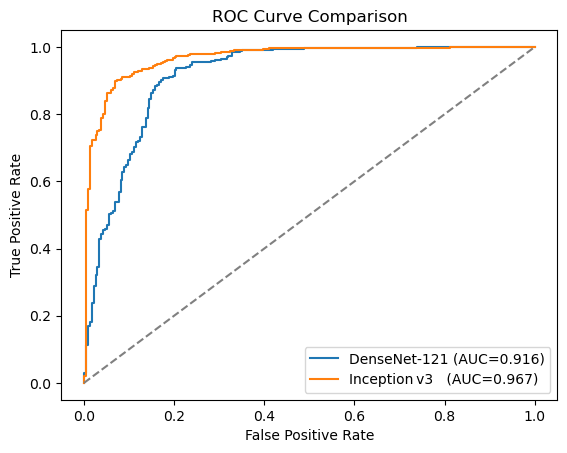

In [22]:
import matplotlib.pyplot as plt

# 2.1) Summary table (in plain Python)
print("Model         | Accuracy  |   ROC‑AUC")
print("--------------------------------------")
print(f"DenseNet‑121  | {dn_acc:.3%} | {dn_auc:.3f}")
print(f"Inception v3  | {acc:.3%} | {auc:.3f}")

# 2.2) Overlay ROC curves
fpr_dn, tpr_dn, _ = roc_curve(dn_labels, dn_probs)
fpr_i,  tpr_i,  _ = roc_curve(all_labels, all_probs)  # these are your Inception lists

plt.figure()
plt.plot(fpr_dn, tpr_dn, label=f"DenseNet‑121 (AUC={dn_auc:.3f})")
plt.plot(fpr_i,  tpr_i,  label=f"Inception v3   (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
